<a href="https://colab.research.google.com/github/billyotieno/analytics-datasets/blob/main/Text_Analysis_of_Hotel_Reviews_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Analytics on Hotel Reviews Dataset (Individual Project)**

The purpose of this notebook is to analyze Hotel Reviews Dataset extracted from Trip Advisor Website in order to achieve the following objectives:

i) To explore key aspects that drive the decisions to give positive reviews & negative reviews.   
ii) To perform topic modeling on the Hotel Reviews dataset - To understand key thematic areas / classes associated with hotel reviews.  
iii) To develop a model that predicts ratings from a guest review.


### 1. Setting Up (Installing Required Libraries)

In [ ]:
# Importing all required libraries (-q quiet installing all libraries)
! pip install -q pandas pandera numpy matplotlib seaborn textblob wordcloud
! pip install -q spacy corenlp 
! pip install -q kaggle
! pip install -q fasttext 
! pip install -q inflect
! pip install -q nltk

In [ ]:
# Install Fast Text for English Language Detection
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2023-01-23 16:50:29--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin.8’

lid.176.bin.8       100%[===================>] 125.18M  47.7MB/s    in 2.6s    

2023-01-23 16:50:32 (47.7 MB/s) - ‘lid.176.bin.8’ saved [131266198/131266198]



###**Sourcing Data from Kaggle** 

In [ ]:
from google.colab import files
!wget https://raw.githubusercontent.com/billyotieno/py_text_processing/main/kaggle.json

--2023-01-23 16:50:32--  https://raw.githubusercontent.com/billyotieno/py_text_processing/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘kaggle.json.8’

kaggle.json.8       100%[===================>]      65  --.-KB/s    in 0s      

2023-01-23 16:50:32 (4.26 MB/s) - ‘kaggle.json.8’ saved [65/65]



In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews

trip-advisor-hotel-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o trip-advisor-hotel-reviews.zip

Archive:  trip-advisor-hotel-reviews.zip
  inflating: tripadvisor_hotel_reviews.csv  


In [ ]:
!mkdir dataset
!cp tripadvisor_hotel_reviews.csv ./dataset/

mkdir: cannot create directory ‘dataset’: File exists


##**Importing Required Libraries**

In [ ]:
# Import required libraries
import pandas as pd
import pandera as pn
import seaborn as sns
import spacy
import re
import nltk
import string
import fasttext
import warnings
import inflect # converting numbers in text to words

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import wordpunct_tokenize
import matplotlib.pyplot as plt

# Pandas settings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

# NLTK Download Options
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Pre-processing Variables Declared
CONTRACTION_MAP = {"ain't": "is not", "aren't": "are not", "can't": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have",
                   "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did",
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                   "I'll've": "I will have", "I'm": "I am", "I've": "I have",
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                   "i'll've": "i will have", "i'm": "i am", "i've": "i have",
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                   "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                   "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                   "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                   "she's": "she is", "should've": "should have", "shouldn't": "should not",
                   "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                   "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                   "they'll've": "they will have", "they're": "they are", "they've": "they have",
                   "to've": "to have", "wasn't": "was not", "we'd": "we would",
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                   "we're": "we are", "we've": "we have", "weren't": "were not",
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                   "what's": "what is", "what've": "what have", "when's": "when is",
                   "when've": "when have", "where'd": "where did", "where's": "where is",
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                   "who's": "who is", "who've": "who have", "why's": "why is",
                   "why've": "why have", "will've": "will have", "won't": "will not",
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                   "you'll've": "you will have", "you're": "you are", "you've": "you have", "n't": "not"}

PUNCTUATIONS = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤','*']



##**Reading the Dataset with Pandas**

In [ ]:
reviews_df = pd.read_csv("./dataset/tripadvisor_hotel_reviews.csv")
reviews_df.head(15)

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5
5,love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husb...,5
6,"cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance com...",5
7,"excellent staff, housekeeping quality hotel chocked staff make feel home, experienced exceptiona...",4
8,"hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bel...",5
9,"excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart...",5


## Initial Data Checks

### Checking Column Data Types

In [ ]:
# Check Data Types
reviews_df.dtypes

Review    object
Rating     int64
dtype: object

### Checking the Dataset Shape

In [ ]:
# Dataset has 20486 reviews and 2 fields/columns
reviews_df.shape

(20491, 2)

### Describing Dataset - `df.describe()`

In [ ]:
# Dataset has total count of 20,491 rows, Mean of Rating Column is 3.95
reviews_df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


### Checking for Missing Values

In [ ]:
# Checking for Missing Values
for col in reviews_df.columns:
  print(col, reviews_df[col].isnull().sum())
# There are no missing values in both review and ratings

Review 0
Rating 0


### Random Scan of Review Text

In [ ]:
# A random scan of individual reviews randomly to inform key pre-processing steps
import random

random_index = random.randint(0, reviews_df.shape[0])
reviews_df.iloc[random_index,0]

"great hotel, read reviews posted tripadvisor planning trip, finding hotel voted 3rd popular hotel beijing immediately checked website seeing average price night, got special rate 80 cad/night including breakfast, really n't think price hotel compete location cleanliness service, concierge staff excellent providing information tours helping city, highly recommend hotel not hesitate return,  "

### Checking Rating Distribution

In [ ]:
reviews_df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

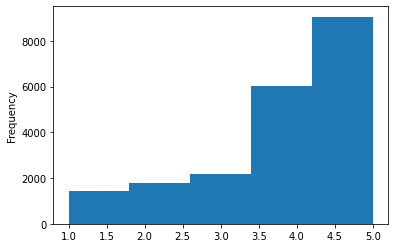

In [ ]:
reviews_df['Rating'].plot(kind="hist", bins=5)

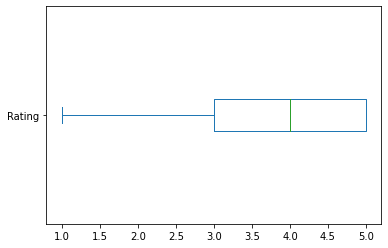

In [ ]:
# Checking the rating distribution
reviews_df['Rating'].plot(kind='box', vert=False)

In [ ]:
# Based on the rating distribution, I'll categorize the rating into 'Positive' rating vs 'Negative' rating. To prepare the dataset for further Text Analytics
# and additional Sentiment Analysis 

# Rating (4 and 5 will map to positive rating), Rating (1, 2, 3 will map to Negative Rating)
def ratings(rating):
  if rating > 3 and rating <= 5:
    return "Positive"
  if rating > 0 and rating <= 3:
    return "Negative"

In [ ]:
# Applying changes to the Rating
reviews_df["Rating"] = reviews_df["Rating"].apply(ratings)

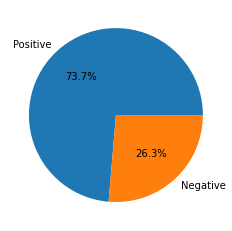

<Figure size 864x1008 with 0 Axes>

In [ ]:
# Distribution of Ratings
plt.pie(reviews_df["Rating"].value_counts(), labels=reviews_df["Rating"].unique().tolist(), autopct='%1.1f%%')
plt.figure(figsize=(12,14))
plt.show()

## **Initial Exploratory Data Analysis**

### Review Text - Exploratory Data Analysis
At this step the objective is to conduct an initial exploration of the review texts.

### Word Cloud for All Reviews - What are the Common Words used in the Review Text?

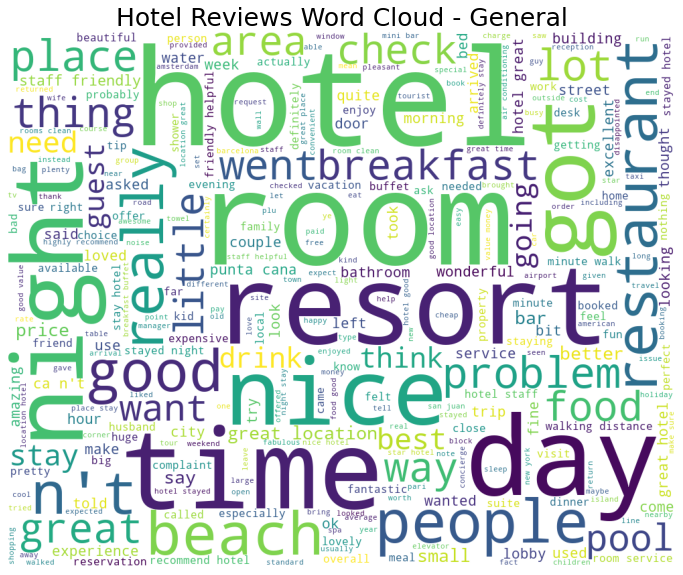

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200,
    width=1000,height=800,
    random_state=42
).generate(" ".join(reviews_df['Review'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize=(12,14))
plt.imshow(wordcloud)
plt.title("Hotel Reviews Word Cloud - General", fontsize=25)
plt.axis('off')
plt.show()

### Word Cloud for Positive Reviews - What are the common words in the Positive Review Text?

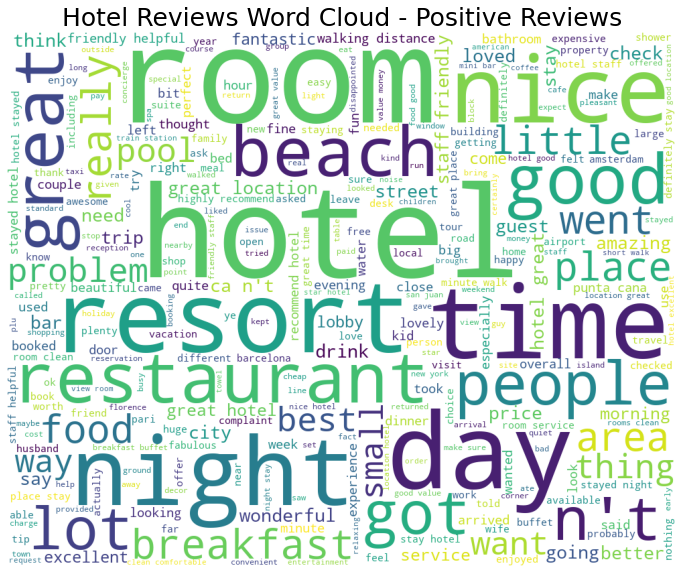

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200,
    width=1000,height=800,
    random_state=42
).generate(" ".join(reviews_df[reviews_df['Rating'] == 'Positive']['Review'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize=(12,14))
plt.imshow(wordcloud)
plt.title("Hotel Reviews Word Cloud - Positive Reviews", fontsize=25)
plt.axis('off')
plt.show()

### Word Clouds of Negative Reviews - What are the common Words in the Negative Review Text?

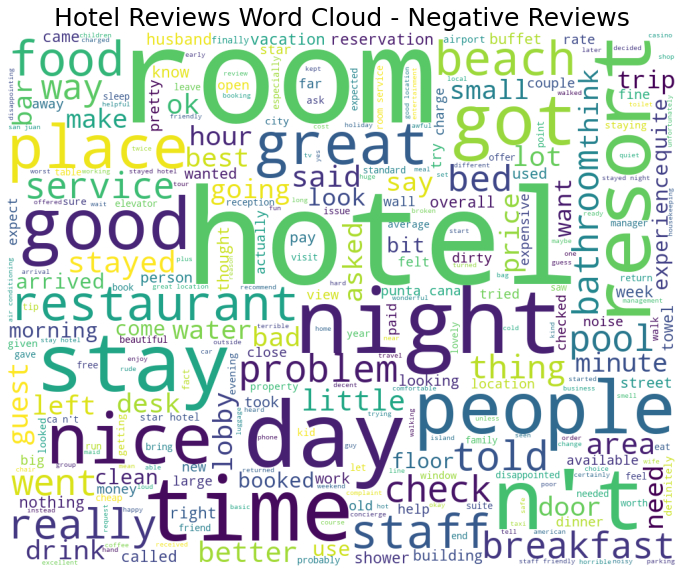

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200,
    width=1000,height=800,
    random_state=42
).generate(" ".join(reviews_df[reviews_df['Rating'] == 'Negative']['Review'].astype(str)))

fig = plt.figure(figsize=(12,14))
plt.imshow(wordcloud)
plt.title("Hotel Reviews Word Cloud - Negative Reviews", fontsize=25)
plt.axis('off')
plt.show()

## **Text Pre-Processing & Cleaning**


**Text Preprocessing**

  - Expanding Contractions 
  - English Language Detection
  - Tokenization
  - Converting all Characters to Lowercase
  - Removing Punctuations
  - Removing Stopwords
  - Stemming vs Lemmatization

#### a) Expanding Contractions

This step we focus on expanding contractions such as didn't to did not.

In [ ]:
# Function to expand contractions
def expand_contractions(sentence, contraction_mapping):
  contractions_pattern = re.compile('({})'.format('|'.join(
      contraction_mapping.keys())),
      flags=re.IGNORECASE | re.DOTALL)

  def expand_match(contraction):
      match = contraction.group(0)
      first_char = match[0]
      expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(
          match) else contraction_mapping.get(match.lower())
      expanded_contraction = first_char + expanded_contraction[1:]
      return expanded_contraction

  expanded_sentence = contractions_pattern.sub(expand_match, sentence)
  return expanded_sentence

In [ ]:
reviews_df["cleaned_reviews"] = reviews_df.Review.apply(
    lambda x: expand_contractions(x, CONTRACTION_MAP)
    )

reviews_df.head(2)

,Review,Rating,cleaned_reviews
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv..."
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta..."


#### b) Seperating Numbers from Words

In [ ]:
def sep_num_words(text):
  """
  Function seperates numbers from words or other characters.
  Args:
    text (str): String of 
  Returns:
    cleaned string with numbers seperated from words and other characters
  """
  return re.sub(r"([0-9]+(\.[0-9]+)?)", r"\1 ", text).strip()

reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(
    lambda x: sep_num_words(x)
)

reviews_df.head(2)

,Review,Rating,cleaned_reviews
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv..."
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,"ok nothing special charge diamond member hilton decided chain shot 20 th anniversary seattle, st..."


#### c) Converting Numbers to Words


In [ ]:
def num_to_word(text):
  p = inflect.engine()
  output_text = []
  for word in text.split():
    if word.isdigit():
      output_text.append(p.number_to_words(word))
    else:
      output_text.append(word)
  return " ".join(output_text)


reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(
    lambda x: num_to_word(x)
)

reviews_df.head(2)

,Review,Rating,cleaned_reviews
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv..."
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,ok nothing special charge diamond member hilton decided chain shot twenty th anniversary seattle...


#### d) English Language Detection

This step focuses on identifying if there are any review that are based on non-english language so that I can remove them from the review we are considering for analysis.

In [ ]:
def classify_reviews_by_lang(df):
  # Loading pre-trained language model to identify the review languages - ## The objective is to only focus on english review.
  pre_trained_model = "lid.176.bin"
  lang_model = fasttext.load_model(pre_trained_model)

  # For each review line, I pass it through the model .predict() function with a resulting language - en,de etc.
  detected_lang  = []

  for review in df["Review"]:
    language = lang_model.predict(review)[0]
    detected_lang.append(str(language)[11:13])

  df["review_language"] = detected_lang
  return df

reviews_df = classify_reviews_by_lang(reviews_df)
reviews_df.head(2)

,Review,Rating,cleaned_reviews,review_language
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",en
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,ok nothing special charge diamond member hilton decided chain shot twenty th anniversary seattle...,en


en    20486
fr        4
de        1
Name: review_language, dtype: int64


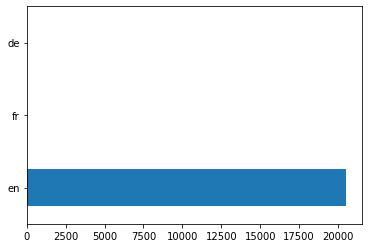

In [ ]:
# Checking the distribution of different languages in the review text
print(reviews_df.review_language.value_counts())
reviews_df.review_language.value_counts().plot(kind='barh')

In [ ]:
# Lets drop the additional languages (5 rows)
def drop_non_english_languages(df):
  other_language_index = df[(df["review_language"] != 'en')].index
  df = df.drop(other_language_index)
  return df

reviews_df = drop_non_english_languages(reviews_df)
reviews_df.shape

(20486, 4)

### e) Converting to Lowercase & Removing Punctuations

In [ ]:
def remove_punctuation(text, punctuations):
  for punctuation in punctuations:
    if punctuation in text:
      text = text.replace(punctuation, '')
    return text.strip().lower()

def remove_punctuation_list(word_token, punctuations):
  for word in word_token:
    if word in punctuations:
      word_token.remove(word)
  return word_token

In [ ]:
# Apply lower_case and punctuation remover to text
reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(lambda x: remove_punctuation(x, PUNCTUATIONS))
reviews_df.head(2)

,Review,Rating,cleaned_reviews,review_language
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advi...,en
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,ok nothing special charge diamond member hilton decided chain shot twenty th anniversary seattle...,en


### f) Tokenization

In [ ]:
reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(lambda x: wordpunct_tokenize(x))
reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(lambda x: remove_punctuation_list(x, PUNCTUATIONS))
reviews_df.head(2)

,Review,Rating,cleaned_reviews,review_language
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, even...",en
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, twenty, th, annive...",en


### g) Removing Stop Words

In [ ]:
from nltk.corpus import stopwords

def remove_stop_words(text):
  stopwords_set = set(stopwords.words('english'))
  return [t for t in text if not t in stopwords_set]

In [ ]:
reviews_df["cleaned_reviews"] = reviews_df["cleaned_reviews"].apply(lambda x: remove_stop_words(x))
reviews_df.head(2)

,Review,Rating,cleaned_reviews,review_language
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, even...",en
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, twenty, th, annive...",en


### h) Lemmatization of Text

In [ ]:
def lemmatize_review(token_list):
  """
  Function takes the lemmatizer object and word_token_list
  Input: Lemmatizer, word_token_list []
  Output: A list of lemmatized word tokens
  Return 
  """
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w) for w in token_list]

In [ ]:
reviews_df["cleaned_reviews"] = \
      reviews_df["cleaned_reviews"].apply(
          lambda x: lemmatize_review(x))
      
reviews_df.tail(3)

,Review,Rating,cleaned_reviews,review_language
20488,"ok just looks nice modern outside, desk staff n't particularly friendly, corridors dark smelt st...",Negative,"[ok, look, nice, modern, outside, desk, staff, particularly, friendly, corridor, dark, smelt, st...",en
20489,"hotel theft ruined vacation hotel opened sept 17 2007 guests week, happy stumble scouting hotels...",Negative,"[hotel, theft, ruined, vacation, hotel, opened, sept, seventeen, two, thousand, seven, guest, we...",en
20490,"people talking, ca n't believe excellent ratings hotel, just n't, yes patricia extremely helpful...",Negative,"[people, talking, ca, believe, excellent, rating, hotel, yes, patricia, extremely, helpful, flue...",en


## **Text Pre-Processing Pipeline Function**
This section combines all the processes for text processing into as single function to enable a single pipeline to parse the text and output a clean dataset function.

In [ ]:
def expand_contractions(sentence, contraction_mapping):
    """Function expands a contraction word within a sentence
       returns a sentence with expanded contraction.

    Args:
        sentence (str): A sentence with a contraction word
        contraction_mapping (dict): A list of contraction and their expanded forms.

    Returns:
        str: A string with expanded contractions
    """
    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
        flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(
            match) else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence


def sep_num_words(text):
    """
    Function seperates numbers from words or other characters e.g. 22ABC to 22 ABC
    Args:
        text (str): String of 
    Returns:
        cleaned string with numbers seperated from words and other characters
    """
    return re.sub(r"([0-9]+(\.[0-9]+)?)", r"\1 ", text).strip()


def num_to_word(text):
    """Function converts numbers in review texts into words.

    Args:
        text (str): A review text 

    Returns:
        str: A review text with numbers converted to words.
    """
    p = inflect.engine()
    output_text = []
    for word in text.split():
        if word.isdigit():
          output_text.append(p.number_to_words(word))
        else:
          output_text.append(word)
    return " ".join(output_text)


def classify_reviews_by_lang(df):
    """Function classifies reviews by language and adds a new column to the dataframe.

    Args:
        df (DataFrame): Reviews DataFrame

    Returns:
        df: A Reviews Dataframe with a new column with classifications.
    """
    # Loading pre-trained language model to identify the review languages - ## The objective is to only focus on english review.
    pre_trained_model = "lid.176.bin"
    lang_model = fasttext.load_model(pre_trained_model)

    # For each review line, I pass it through the model .predict() function with a resulting language - en,de etc.
    detected_lang  = []

    for review in df["Review"]:
        language = lang_model.predict(review)[0]
        detected_lang.append(str(language)[11:13])

    df["review_language"] = detected_lang
    return df


def drop_non_english_languages(df):
    """Function drops all the non-english languages from the DataFrame

    Args:
        df (DataFrame): DataFrame Object

    Returns:
        df: Returns a DataFrame with non-english languages dropped.
    """
    other_language_index = df[(df["review_language"] != 'en')].index
    df = df.drop(other_language_index)
    return df


def remove_punctuation(text, punctuations):
    """Function removes all punctuations from text.

    Args:
        text (str): A string text with or without punctuations.
        punctuations (List): A list of common punctuations.

    Returns:
        str: Returns a string cleaned of punctuations
    """
    for punctuation in punctuations:
        if punctuation in text:
            text = text.replace(punctuation, '')
        return text.strip().lower()


def remove_punctuation_list(word_token, punctuations):
    """Function removes all punctuations from a List of Tokens.

    Args:
        word_token (List): A list of Word Tokens.
        punctuations (List): A list of punctuations.

    Returns:
        List: A list of word tokens without punctuation tokens.
    """
    for word in word_token:
        if word in punctuations:
          word_token.remove(word)
    return word_token


def remove_stop_words(text):
    """Function removes stop words from word token list.

    Args:
        text (str): Review text corpus. 

    Returns:
        List: A list of word token without stop words.
    """
    stopwords_set = set(stopwords.words('english'))
    return [t for t in text if not t in stopwords_set]


def lemmatize_review(token_list):
    """
    Function takes the lemmatizer object and word_token_list
    Input: Lemmatizer, word_token_list []
    Output: A list of lemmatized word tokens
    Return 
    """
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in token_list]


def preprocess_hotel_reviews(df, CONTRACTION_MAP, PUNCTUATIONS):
    """
    Function take Dataframe, Contraction Mapping and Punctuations and returns a cleaned DataFrame
    with Tokenized Review Column
    Args:
        df (DataFrame): A DataFrame Object
        CONTRACTION_MAP (dict): A dictionary of contractions
        PUNCTUATIONS (list): A list of punctuations to remove from text
    Returns: 
        Returns a DataFrame Object
    """
    df = df.copy()
    # create a new review column for initial review column
    df["cleaned_reviews"] = df["Review"]
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: expand_contractions(x, CONTRACTION_MAP))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: sep_num_words(x))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: num_to_word(x))

    # Classify reviews by language
    classify_reviews_by_lang(df)
    # Drop non-english reviews
    drop_non_english_languages(df)

    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: remove_punctuation(x, PUNCTUATIONS))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: wordpunct_tokenize(x))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: remove_punctuation_list(x, PUNCTUATIONS))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: remove_stop_words(x))
    df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda x: lemmatize_review(x))

    return df

In [ ]:
%%time
reviews_df = preprocess_hotel_reviews(reviews_df, CONTRACTION_MAP, PUNCTUATIONS)
reviews_df.head(6)

CPU times: user 38.2 s, sys: 465 ms, total: 38.6 s
Wall time: 38.6 s


,Review,Rating,cleaned_reviews,review_language
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",Positive,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, even...",en
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",Negative,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, twenty, th, annive...",en
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,Negative,"[nice, room, four, experience, hotel, monaco, seattle, good, hotel, four, level, positive, large...",en
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",Positive,"[unique, great, stay, wonderful, time, hotel, monaco, location, excellent, short, stroll, main, ...",en
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",Positive,"[great, stay, great, stay, went, seahawk, game, awesome, downfall, view, building, complain, roo...",en
5,love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husb...,Positive,"[love, monaco, staff, husband, stayed, hotel, crazy, weekend, attending, memorial, service, best...",en
